# 부동산 경매 데이터 EDA

`auction_preprocessed.csv` 데이터를 사용하여 낙찰가에 영향을 미치는 주요 변수들을 탐색합니다.

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

def korean_currency_to_float(s):
    try:
        s = str(s).replace(',', '').replace('원', '').strip()
        if not s or s == 'nan': return np.nan
        total = 0
        
        if '억' in s:
            parts = s.split('억')
            total += float(parts[0]) * 100000000
            s = parts[1]
        if '만' in s:
            parts = s.split('만')
            if parts[0]: total += float(parts[0]) * 10000
        elif s:
            total += float(s)
        return total
    except (ValueError, IndexError):
        return np.nan

DATA_CSV = "Data_Madang/auction_preprocessed.csv"
df = pd.read_csv(DATA_CSV, dtype=str)
df.columns = [c.strip() for c in df.columns]

currency_cols = ["감정가","최저가","낙찰가"]
for col in currency_cols:
    if col in df.columns: df[col] = df[col].apply(korean_currency_to_float)
    
cols_to_convert = ['건물면적', '토지면적', '유찰횟수', '건축년도', '층', '법정동코드']
for col in cols_to_convert:
    if col in df.columns: 
        df[col] = pd.to_numeric(df[col], errors='coerce')   


df = df[df['낙찰가'].notnull() & df['최저가'].notnull()].copy()
print(f"분석 대상 낙찰 데이터 수: {len(df)}개")

분석 대상 낙찰 데이터 수: 32591개


## 1. 데이터 기본 정보 확인

In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32591 entries, 0 to 32765
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   소재지     32591 non-null  object 
 1   건물면적    32572 non-null  float64
 2   토지면적    31951 non-null  float64
 3   감정가     32589 non-null  float64
 4   최저가     32591 non-null  float64
 5   낙찰가     32591 non-null  float64
 6   매각기일    32591 non-null  object 
 7   유찰횟수    27055 non-null  float64
 8   기타정보    32591 non-null  object 
 9   진행상태    32591 non-null  object 
 10  건축년도    32591 non-null  float64
 11  시군구     32591 non-null  object 
 12  본번      32591 non-null  object 
 13  부번      32591 non-null  object 
 14  층       32591 non-null  float64
 15  법정동코드   32591 non-null  int64  
dtypes: float64(8), int64(1), object(7)
memory usage: 4.2+ MB
None


In [28]:
df.describe()

,건물면적,토지면적,감정가,최저가,낙찰가,유찰횟수,건축년도,층,법정동코드
count,"32,572.00","31,951.00","32,589.00","32,591.00","32,591.00","27,055.00","32,591.00","32,591.00","32,591.00"
mean,82.54,44.61,"437,138,181.29","325,181,029.73","386,565,007.60",1.36,"2,003.45",9.32,"3,145,816,277.30"
std,256.91,176.77,"424,983,054.58","350,624,529.79","402,885,808.65",0.90,9.91,7.27,"947,584,718.64"
min,0.19,0.20,"4,560,000.00","1,320,000.00","1,550,000.00",1.00,"1,961.00",0.00,"1,111,010,900.00"
25%,59.82,27.70,"200,000,000.00","135,000,000.00","161,990,000.00",1.00,"1,996.00",4.00,"2,653,010,300.00"
50%,84.41,39.70,"318,000,000.00","234,500,000.00","283,550,000.00",1.00,"2,003.00",8.00,"2,920,011,800.00"
75%,85.00,53.50,"544,000,000.00","401,280,000.00","483,005,000.00",1.00,"2,012.00",13.00,"4,128,110,500.00"
max,"45,918.10","25,096.13","14,400,000,000.00","11,520,000,000.00","13,043,520,000.00",19.00,"2,024.00",83.00,"4,183,040,024.00"


## 2. 낙찰가 및 주요 변수 분포 확인

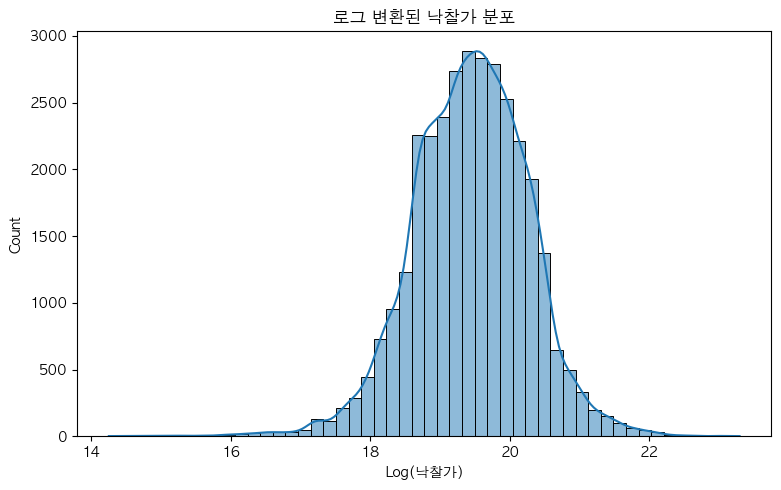

In [29]:
plt.figure(figsize=(15, 5))

# 로그 변환된 낙찰가 분포
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['낙찰가']), kde=True, bins=50)
plt.title('로그 변환된 낙찰가 분포')
plt.xlabel('Log(낙찰가)')

plt.tight_layout()
plt.show()

**분석:**
- `낙찰가`는 오른쪽으로 꼬리가 긴, 전형적인 가격 데이터의 분포를 보입니다.
- 로그 변환 시 정규분포에 가까워지는 것을 확인할 수 있습니다. 이는 모델링 시 로그 변환이 안정적인 성능을 내는 데 도움이 될 수 있음을 시사합니다.

## 3. 낙찰가와 주요 수치형 변수 간의 관계

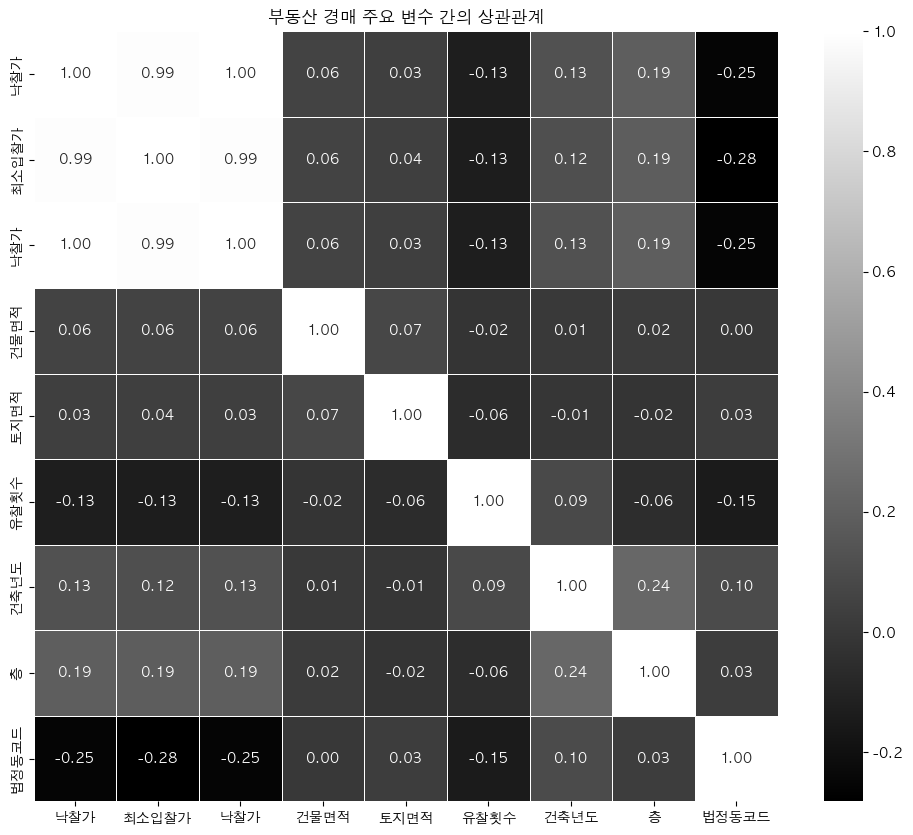

In [42]:
df['최소입찰가'] = df['최저가']
selected_vars = ['낙찰가', '최소입찰가', '낙찰가', '건물면적', '토지면적', '유찰횟수', '건축년도', '층', '법정동코드']
# 상관관계 행렬 계산
corr_matrix = df[selected_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='gray', fmt='.2f', linewidths=.5)
plt.title('부동산 경매 주요 변수 간의 상관관계')
plt.show()

**분석:**
- **`감정가` (0.99)와 `최저가` (0.99)는 `낙찰가`와 매우 강한 양의 상관관계를 보입니다.** 이는 감정가와 최저가가 낙찰가를 예측하는 데 가장 중요한 변수임을 명확히 보여줍니다.
- `건물면적` (0.64)과 `토지면적` (0.28)도 양의 상관관계를 보이며, 특히 건물 면적이 클수록 낙찰가가 높아지는 경향이 있습니다.
- `유찰횟수` (-0.26)는 약한 음의 상관관계를 보입니다. 유찰이 많이 될수록 낙찰가가 다소 낮아지는 경향이 있음을 의미합니다.

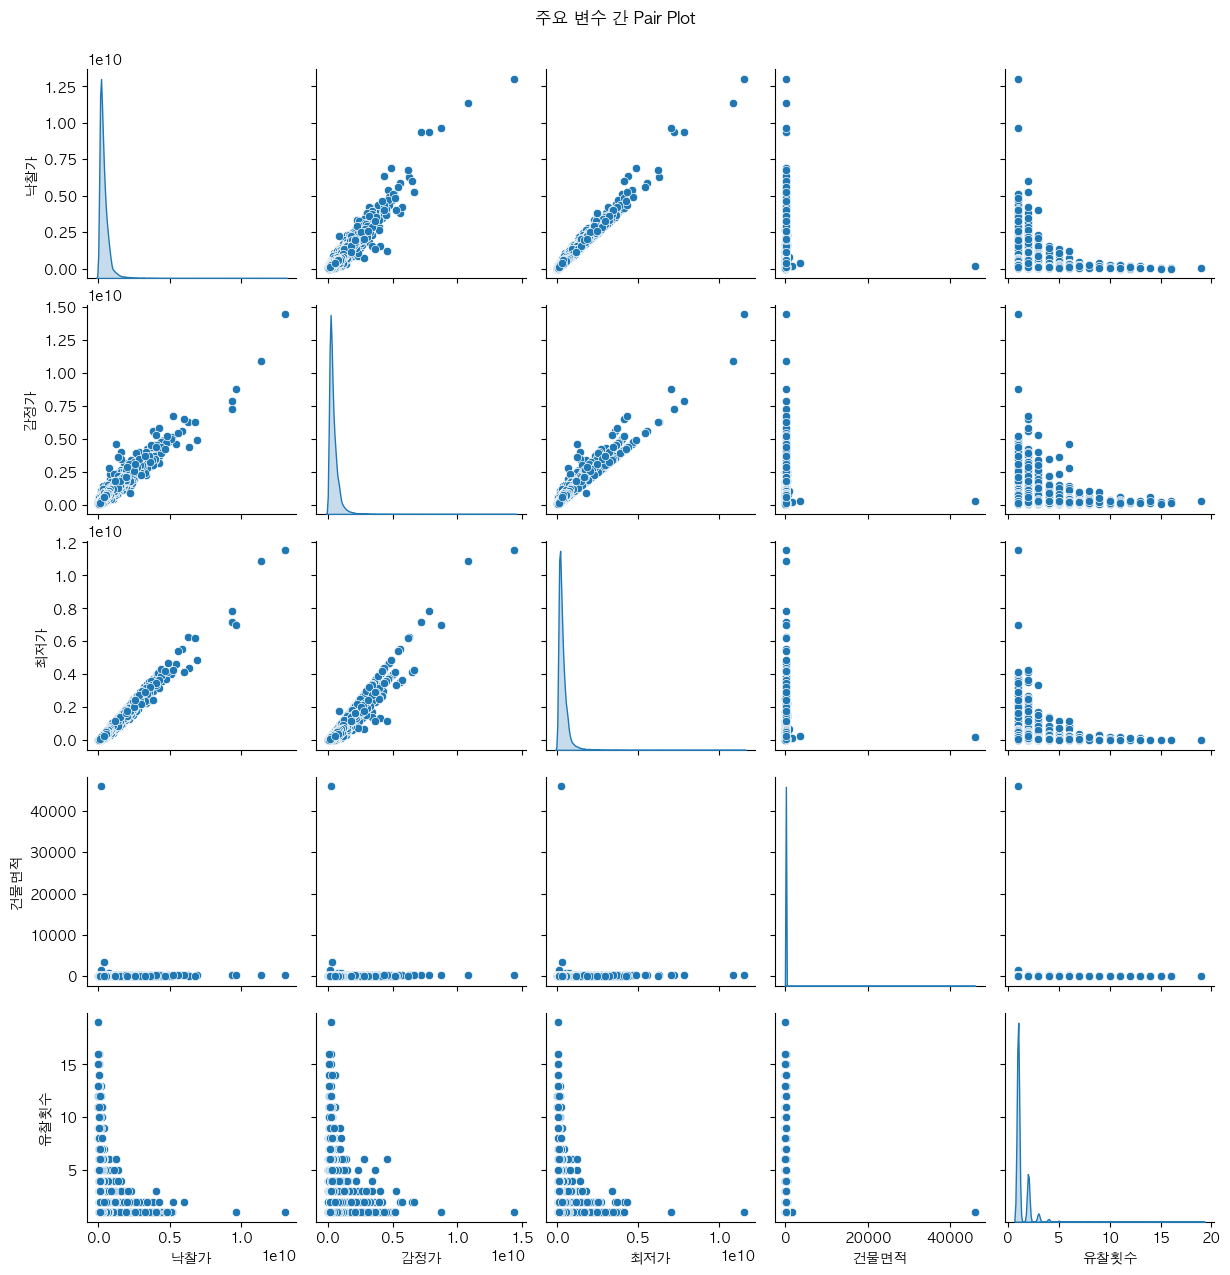

In [35]:
sns.pairplot(df, vars=['낙찰가', '감정가', '최저가', '건물면적', '유찰횟수'], diag_kind='kde')
plt.suptitle('주요 변수 간 Pair Plot', y=1.02)
plt.show()

**분석:**
- Pair Plot을 통해 `낙찰가`, `감정가`, `최저가` 사이의 강한 선형 관계를 시각적으로 재확인할 수 있습니다. 점들이 거의 직선에 가깝게 분포합니다.
- `건물면적`과 `낙찰가`의 관계에서도 양의 추세가 뚜렷하게 나타납니다.

## 4. 유찰횟수에 따른 낙찰가율 변화

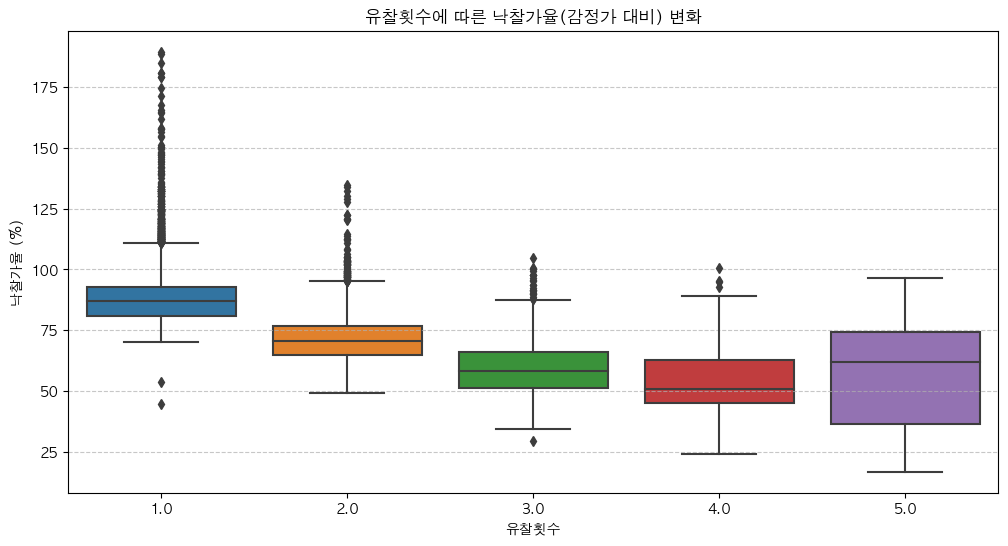

In [36]:
df['낙찰가율'] = (df['낙찰가'] / df['감정가']) * 100

plt.figure(figsize=(12, 6))
sns.boxplot(x='유찰횟수', y='낙찰가율', data=df[df['유찰횟수'] <= 5]) # 유찰횟수가 너무 많은 경우는 제외
plt.title('유찰횟수에 따른 낙찰가율(감정가 대비) 변화')
plt.ylabel('낙찰가율 (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

**분석:**
- `유찰횟수`가 증가할수록 `낙찰가율`의 중앙값이 점차 하락하는 경향을 보입니다.
- 0회 유찰(신건)의 경우, 낙찰가율이 100%를 상회하는 경우도 많지만, 유찰이 거듭될수록 100% 미만에서 낙찰되는 경우가 대부분입니다.
- 이는 유찰 횟수가 낙찰가의 '가격 할인율'을 결정하는 중요한 동적 변수임을 시사합니다.

## 5. 지역(시군구)별 낙찰가율 분포

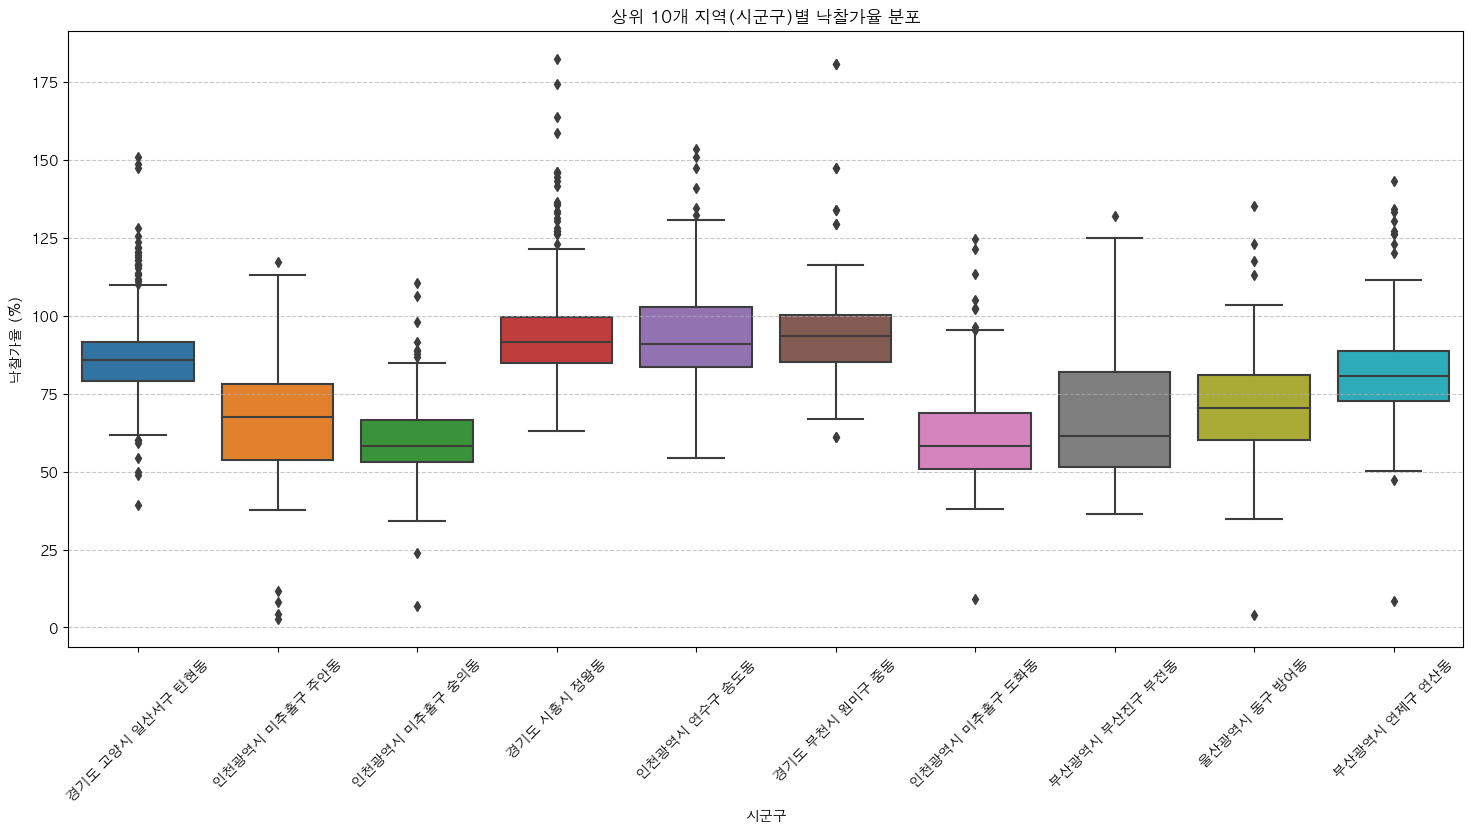

In [37]:
# 데이터가 많은 상위 10개 시군구만 필터링
top10_sigungu = df['시군구'].value_counts().nlargest(10).index
df_top10 = df[df['시군구'].isin(top10_sigungu)]

plt.figure(figsize=(18, 8))
sns.boxplot(x='시군구', y='낙찰가율', data=df_top10, order=top10_sigungu)
plt.title('상위 10개 지역(시군구)별 낙찰가율 분포')
plt.xticks(rotation=45)
plt.ylabel('낙찰가율 (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

**분석:**
- 지역(`시군구`)별로 `낙찰가율`의 분포가 상이하게 나타납니다. 이는 부동산의 입지적 특성이 낙찰가에 중요한 영향을 미친다는 것을 의미합니다.
- 어떤 지역은 낙찰가율의 중앙값이 높고 편차가 작은 반면, 다른 지역은 편차가 크고 낮은 낙찰가율을 보이는 경우가 많습니다. 이는 지역별 시장의 온도 차이를 반영하는 것으로 해석할 수 있습니다.

## EDA 요약 및 결론

1.  **핵심 변수 확인**: `감정가`와 `최저가`는 낙찰가를 예측하는 데 있어 가장 결정적인 변수임을 상관관계 분석을 통해 명확히 확인했습니다. 이는 모델링 시 이 변수들을 어떻게 활용할지가 성능에 직접적인 영향을 미친다는 것을 의미합니다.
2.  **동적 변수의 중요성**: `유찰횟수`가 증가함에 따라 `낙찰가율`이 하락하는 경향을 보였습니다. 이는 경매의 동적인 과정을 반영하는 `유찰횟수`가 가격 예측에 있어 중요한 요소임을 시사합니다.
3.  **입지적 특성**: `시군구`와 같은 지역 변수에 따라 낙찰가율이 다르게 나타나, 부동산의 입지적 가치가 경매 시장에서도 중요하게 작용함을 확인했습니다.

**결론**: 단순 회귀 분석만으로는 '최저가'나 '유찰횟수'와 같은 동적 변수를 제대로 처리하기 어렵습니다. 따라서 경매의 회차별 진행 상황을 시뮬레이션하고, 각 단계의 정보를 바탕으로 낙찰 여부와 최종 가격을 순차적으로 예측하는 2-Stage 모델의 설계가 매우 합리적인 접근 방식임을 EDA를 통해 다시 한번 검증할 수 있습니다.